In [2]:
import numpy as np
import scipy as sp
import math
#get prepared for spaghetti an Italian grandmother would be proud of

#finds spectrogram, yes I spelled it wrong
def specto(data,window,overlap):#data to find the spectrogram of, window used, overlap
    nwindow=window.shape[0]#length of window
    nframes=math.floor(1.0+1/(1.0-overlap)*(len(data)/nwindow-1.0))#number of frames
    sgram=np.zeros((nwindow,nframes))#initialize
    hop=math.floor((1.0-overlap)*nwindow)#hop size
    for i in range(nframes):
        datawin=data[i*hop:(i)*hop+nwindow]#data in frame
        sgram[:,i]=np.abs(np.fft.fft(window*datawin))#spectrogram in frame
    return(sgram)#spectrogram

In [8]:
#does pca
def pca(X,k):#data to do pca on, number of dimensions held
    X=np.subtract( X,np.mean(X,0))#make 0 mean
    covx=np.dot(X,np.transpose(X))/(X.shape[1]-1)#find cov(X)
    evals,U=np.linalg.eig(covx)#find eigenvalues
    #plt.plot(np.log(evals))
    sqrtevals=np.diag(np.power(evals+.000000001,-.5))#inverse square root of eigenvalyes along diaginol
    W=np.dot(sqrtevals[0:k,0:k],np.transpose(U[:,0:k]))#multiply with eigenvectors and drop all but k dimensions to get features
    return(np.real(W))#features

In [3]:
A=np.loadtxt("/home/alan/Desktop/testout.txt", delimiter=",").T
B=np.loadtxt("/home/alan/Desktop/testout2.txt", delimiter=",").T

In [57]:
import matplotlib.pyplot as plt

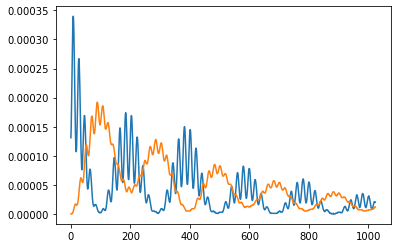

In [75]:
plt.plot(A[0,:])
plt.plot(A[1,:])

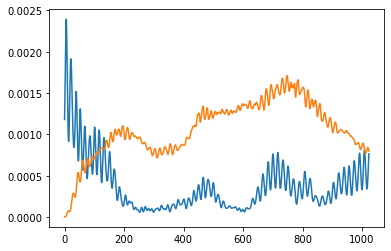

In [77]:
plt.plot(A[0,:])
plt.plot(A[1,:])

In [74]:
from numpy.linalg import inv
from numpy.linalg import det
def problemall2(trainlist,classlist,testlist,priors,k):#training set, classified data, test data, priors, number of dimensions
    mus=[]#averages
    covinvs=[]#inverse covariance matrices
    classes=[]#classes
    covdets=[]#determinants of covariance matrices
    A=[]#coefficients in g equation
    B=[]
    C=[]
    W=pca(trainlist,k)#do pca
    for i in range(len(classlist)):
        itrain=classlist[i]
        WD=np.matmul(W,itrain)#reduce dimension
        covinvs.append(inv(np.matmul(WD,np.transpose(WD))/(WD.shape[1]-1)))#inverse covariance matrix
        covdets.append(1/det(covinvs[i]))#determinant
        mus.append(np.mean(WD,axis=1))#average
        A.append(-0.5*covinvs[i])#find coefficients
        B.append(np.matmul(mus[i].T,covinvs[i]))
        C.append(-0.5*np.matmul(B[i],mus[i])-0.5*np.log(np.asarray(covdets[i]))+np.log(priors[i]))
    for i in range(len(testlist)):#for each piece of test data
        testdata=np.matmul(W,testlist[i])#reduce dimension
        classmax=-np.inf#to find the maximum
        classs=-1#closest class, -1 for error
        for j in range(len(classlist)):#yes, I know it's inefficient, I couldn't get the matrix form to work
            g=np.dot(testdata.T,np.matmul(A[j],testdata))+np.matmul(B[j],testdata)+C[j]#find g
            if g>classmax:#compare to old best match
                 classmax=g#update
                 classs=j#best match is now j
        classes.append(classs)
    return classes

In [71]:
Arand=A+30*np.random.randn(1025,10000)

In [76]:
trainlabels=np.array([A[0,i] for i in range(10000) if i%10==0])
testlabels=[A[0,i] for i in range(10000) if i%10!=0]

In [25]:
train=np.array([A[1:,i] for i in range(10000) if i%10==0]).T
test=[B[1:,i] for i in range(10000) if i%10!=0]
classtrain=[train[:,0:400], train[:,400:]]

In [72]:
train=np.array([Arand[1:,i] for i in range(10000) if i%10==0]).T
test=[Arand[1:,i] for i in range(10000) if i%10!=0]
classtrain=[train[:,0:400], train[:,400:]]

In [77]:
classtest=problemall2(train,classtrain,test,[.4,.6],20)
sum(classtest==(np.array(testlabels)>.15))/9000

0.7802222222222223

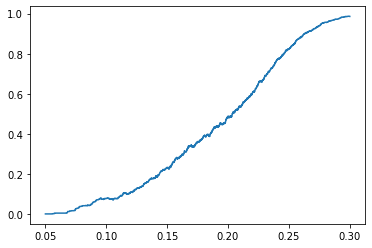

In [78]:
plt.plot(testlabels,np.convolve(classtest,np.ones(1000)*.001)[:9000])

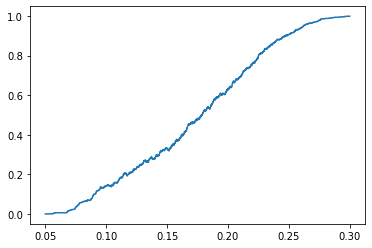

In [16]:
plt.plot(testlabels,np.convolve(classtest,np.ones(1000)*.001)[:9000])

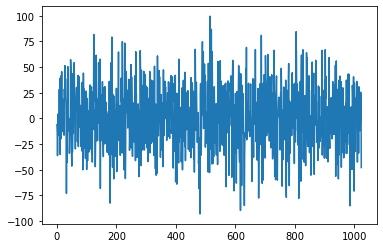

In [68]:
plt.plot(Arand[1:,0])

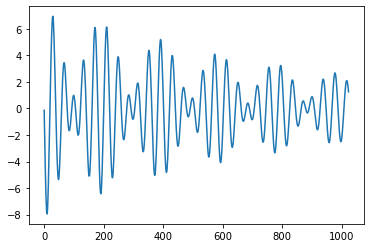

In [51]:
plt.plot(A[1:,0])

In [33]:
def HMM2(train,nclusters,transin,musin,covvin,priorsin):##Why did I write this? You even warned me.
    dims=train.shape[1]
    lentrain=train.shape[0]
    #Initalize everything
    alpha=np.zeros((lentrain,nclusters))
    beta=np.zeros((lentrain,nclusters))
    gamma=np.zeros((lentrain,nclusters))
    xi=np.zeros((lentrain-1,nclusters,nclusters))
    trans=transin
    oldtrans=trans
    mus=musin
    covv=covvin
    priors=priorsin
    gamma[0,:]=priors
    
    

    c=np.zeros(lentrain)
    s=np.zeros(lentrain)
    
    #print(priors)
    #print(dims)
    #print(covv)
    #print(mus)
    
    
    
    for j in range(100):
    ##############E step
        #print(det(covv[0,:,:]))
        ###FORWARD PASS
        for l in range(nclusters):
            #calculate first alpha
            alpha[0,l]=priors[l]*(6.28318530718)**(-0.5*dims)*det(covv[l,:,:])**(-0.5)*np.exp(-0.5*(np.dot((train[0,:]-mus[l,:]).T,np.dot(inv(covv[l,:,:]),train[0,:]-mus[l,:]))))
        #normalize to avoid underflow. This makes alpha too big but evenly too big at each time step. Because we
        #divide by alpha*beta at all timesteps when we use it, prod(c) cancels out and we get the right answer.
        c[0]=1/np.sum(alpha[0,:]) 
        for l in range(nclusters):
            alpha[0,l]=alpha[0,l]*c[0]
        for k in range(lentrain-1):#calculate other alphas
            for l in range(nclusters):
                alpha[k+1,l]=(6.28318530718)**(-0.5*dims)*det(covv[l,:,:])**(-0.5)*np.exp(-0.5*(np.dot((train[k+1,:]-mus[l,:]).T,np.dot(inv(covv[l,:,:]),train[k+1,:]-mus[l,:]))))*np.dot(alpha[k,:],trans[:,l])
            c[k+1]=1/np.sum(alpha[k+1,:])
            for l in range(nclusters):
                alpha[k+1,l]=alpha[k+1,l]*c[k+1]
            
        ###BACK PASS
        for l in range(nclusters):
            beta[lentrain-1,l]=c[lentrain-1]#using the above constants to avoid underflow
            #beta[lentrain-1,l]=c[lentrain-1]*priors[l]*(6.28318530718)**(-0.5*dims)*det(covv[l,:,:])**(-0.5)*np.exp(-0.5*(np.dot((train[lentrain-1,:]-mus[l,:]).T,np.dot(inv(covv[m,:,:]),train[lentrain-1,:]-mus[l,:]))))
        for k in range(lentrain-1):
            for l in range(nclusters):
                beta[lentrain-k-2,l]=0;
                for m in range(nclusters):
                    beta[lentrain-k-2,l]+=c[lentrain-k-2]*(6.28318530718)**(-0.5*dims)*det(covv[m,:,:])**(-0.5)*np.exp(-0.5*(np.dot((train[lentrain-k-1,:]-mus[m,:]).T,np.dot(inv(covv[m,:,:]),train[lentrain-k-1,:]-mus[m,:]))))*beta[lentrain-k-1,m]*trans[l,m]
                    #beta[lentrain-k-2,l]+=(6.28318530718)**(-0.5*dims)*det(covv[m,:,:])**(-0.5)*np.exp(-0.5*(np.dot((train[lentrain-k-1,:]-mus[m,:]).T,np.dot(inv(covv[m,:,:]),train[lentrain-k-1,:]-mus[m,:]))))*beta[lentrain-k-1,m]*trans[l,m]
            #cb=1/np.sum(beta[lentrain-k-2,:])
            #for l in range(nclusters):
                #beta[lentrain-k-2,l]=beta[lentrain-k-2,l]*cb
        for k in range(lentrain):
            for l in range(nclusters):
                #print("alpha", alpha[k,l])
                #print("beta", beta[k,l])
                #print("c",c[k])
                gamma[k,l]=alpha[k,l]*beta[k,l]#posteriors
            s[k]=sum(gamma[k,:])
            for l in range(nclusters):
                gamma[k,l]=gamma[k,l]/s[k]#this is where c cancels out for example
        #######################M step
        for k in range(lentrain-1):
            for l in range(nclusters):
                for m in range(nclusters):
                    xi[k,l,m]=alpha[k,l]*trans[l,m]*beta[k+1,m]*(6.28318530718)**(-0.5*dims)*det(covv[l,:,:])**(-0.5)*np.exp(-0.5*(np.dot((train[k+1,:]-mus[l,:]).T,np.dot(inv(covv[l,:,:]),train[k+1,:]-mus[l,:]))))/s[k]
                #gamma[k,l]=sum(xi[k,l,:])
        priors=gamma[0,:]/sum(gamma[0,:])#update everything
        for l in range(nclusters):
            for d in range(dims):
                mus[l,d]=np.dot(gamma[:,l],train[:,d])/np.sum(gamma[:,l])
        for l in range(nclusters):
            for d in range(dims):
                #for e in range(dims):
                covv[l,d,d]=sum([gamma[i,l]*(train[i,d]-mus[l,d])*(train[i,d]-mus[l,d]) for i in range(lentrain)])/np.sum(gamma[:,l])
                #    covv[l,d,e]=sum([gamma[i,l]*(train[i,d]-mus[l,d])*(train[i,e]-mus[l,e]) for i in range(lentrain)])/np.sum(gamma[:,l])
        for l in range(nclusters):
            for m in range(nclusters):
                trans[l,m]=np.sum(xi[:,l,m])/(np.sum(xi[:,l,:]))
        #print(j)
        #if(np.sum(np.abs(trans-oldtrans))/np.sum(trans)<.05):
            #return [mus,covv,trans]
        oldtrans=trans
        #print(beta)
    return [mus,covv,trans,priors]

In [32]:
from numpy.linalg import inv
from numpy.linalg import det
def GMM4(train,nclusters,classes):
    #priors=np.array([sum(np.asarray(classes)==l) for l in range(nclusters)])
    #priors=priors/sum(priors)
    priors=np.zeros(nclusters)
    priors=np.ones(nclusters)/nclusters
    
    
    
    dims=train.shape[1]
    lentrain=train.shape[0]
    mus=np.zeros((nclusters,dims))
    N=np.zeros(nclusters)
    covv=np.zeros((nclusters,dims,dims))
    #covv=list(range(nclusters))
    for l in range(nclusters):
        covv[l,:,:]=np.eye(dims)
        #mus[l,:]=train[l*lentrain//nclusters,:]
    mus[0,:]=train[20,:]
    mus[1,:]=train[40,:]
    mus[2,:]=train[59,:]
    gamma=np.zeros((lentrain,nclusters))
    #for k in range(lentrain):
        #for l in range(nclusters):
            #gamma[k,l]=1*(classes[k]==l)
            #gamma[k,l]=0.33333333
    for j in range(500):
        for k in range(lentrain):
            for l in range(nclusters):
                #calculate posteriors
                gamma[k,l]=priors[l]*(det(covv[l,:,:]))**(-0.5)*np.exp(-0.5*(np.dot((train[k,:]-mus[l,:]).T,np.dot(inv(covv[l,:,:]),train[k,:]-mus[l,:])) ))
            gamma[k,:]=gamma[k,:]/sum(gamma[k,:])#normalize

        for l in range(nclusters):
            N[l]=sum(gamma[:,l])#expected number
            priors[l]=N[l]/lentrain#update priors
            for d in range(dims):#update centers
                mus[l,d]=np.dot(gamma[:,l],train[:,d])/N[l]
            for d in range(dims):#update spreads
                #for e in range(dims):
                #    covv[l,d,e]=sum([gamma[i,l]*(train[i,d]-mus[l,d])*(train[i,e]-mus[l,e]) for i in range(lentrain)])/np.sum(gamma[:,l])#np.dot(np.multiply(posteriors[:,l],(train-centers[:,l]).T),train-centers[:,l])/N[l]
                covv[l,d,d]=sum([gamma[i,l]*(train[i,d]-mus[l,d])*(train[i,d]-mus[l,d]) for i in range(lentrain)])/np.sum(gamma[:,l])#np.dot(np.multiply(posteriors[:,l],(train-centers[:,l]).T),train-centers[:,l])/N[l]
        #print((det(covv[1,:,:]))**(-0.5)*np.exp(-0.5*(np.dot((train[0,:]-mus[1,:]).T,np.dot(covv[1,:,:],train[0,:]-mus[1,:])) )))
        #print(mus[1,:])
    return (gamma,mus,covv)

In [61]:
##How I would test the data, if I had data to test. 
def HMMtest(mumat,priormat,covvmat,transmat,train,digitnum,trainnum,nclusters):
    logprobs=np.zeros((digitnum,1))#
    dims=train.shape[1]
    lentrain=train.shape[0]
    alpha=np.zeros((lentrain,nclusters))
    for i in range(digitnum):#for each digit
        if 1:#for i in range(trainnum):#for each training data from that digit
            #train=testmat[i]#take the HMM output
            mus=mumat[i]
            priors=priormat[i]
            covv=covvmat[i]
            trans=transmat[i]
            c=np.zeros(lentrain)
            #run the forward pass
            for l in range(nclusters):
                alpha[0,l]=priors[l]*(6.28318530718)**(-0.5*dims)*det(covv[l,:,:])**(-0.5)*np.exp(-0.5*(np.dot((train[0,:]-mus[l,:]).T,np.dot(inv(covv[l,:,:]),train[0,:]-mus[l,:]))))
            c[0]=1/np.sum(alpha[0,:])
            for l in range(nclusters):
                alpha[0,l]=alpha[0,l]*c[0]
            for k in range(lentrain-1):
                for l in range(nclusters):
                    alpha[k+1,l]=(6.28318530718)**(-0.5*dims)*det(covv[l,:,:])**(-0.5)*np.exp(-0.5*(np.dot((train[k+1,:]-mus[l,:]).T,np.dot(inv(covv[l,:,:]),train[k+1,:]-mus[l,:]))))*np.dot(alpha[k,:],trans[:,l])
                c[k+1]=1/np.sum(alpha[k+1,:])
                for l in range(nclusters):
                    alpha[k+1,l]=alpha[k+1,l]*c[k+1]
            #the path integral value is normally just the last alpha but we multipled by c[k] at each k so we need to
            #divide by prod(c[k] for all k), which is done in log space for ease's sake
            
            logprobs[i,0]=-np.sum(np.log(c))#np.log(alpha[lentrain-1])
    #take the mean of training data in each digit, then find the max. I don't know if this is a good metric or not.
    return np.argmin(logprobs)

In [34]:
mumat=[]
priormat=[]
covvmat=[]
transmat=[]
Wsgrams=[]
window=np.hamming(20)
sgramLE=np.log(specto(A[1:,2000],window,.5))
sgramHE=np.log(specto(A[1:,8000],window,.5))
W=pca(np.concatenate((sgramLE,sgramHE),axis=1),5)
Wsgrams.append(np.dot(W,sgramLE).T)
Wsgrams.append(np.dot(W,sgramHE).T)
for i in range(2):
    gamma,musin,covvin=GMM4(Wsgrams[i],3,[])
    priorsin=np.zeros(3)
    for i in range(3):
        priorsin[i]=sum(np.argmax(gamma, axis=1)==i)/101##priors
    transin=np.zeros((3,3))
    for i in range(100):
        transin[int(np.argmax(gamma, axis=1)[i]),int(np.argmax(gamma, axis=1)[i+1])]+=1
    for i in range(3):
        transin[i,:]=transin[i,:]/sum(transin[i,:])
    print(musin)
    [musout,covvout,transout,priorsout]=HMM2(Wsgram,3,transin,musin,covvin,priorsin)
    mumat.append(musout)
    covvmat.append(covvout)
    transmat.append(transout)
    priormat.append(priorsout)


[[ 1.34135952  0.16923813 -0.18669059 -0.12772404  1.09218186]
 [ 0.76025131 -1.36022651  0.61507005  0.15110725  0.02932155]
 [ 0.96889571 -0.47449673 -0.54300639  0.20079469 -0.00719666]]
[[ 1.30040647  1.46092789  0.15278968 -0.56242735  0.51390175]
 [ 0.88885637  0.1063986   1.51254109 -0.50906582 -0.52112087]
 [ 0.89332395 -0.00213708 -0.25459353 -0.00831284 -0.69085649]]


In [69]:
hmmclasses=[]
for i in range(10000):
    window=np.hamming(20)
    sgram=np.log(specto(A[1:,i],window,.5))
    Wsgram=np.dot(W,sgram).T
    x=HMMtest(mumat,priormat,covvmat,transmat,Wsgram,2,1,3)
    hmmclasses.append(x)

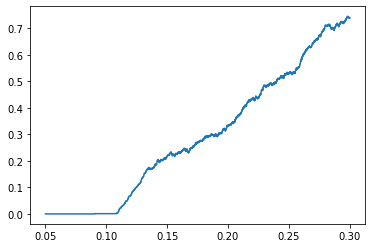

In [70]:
plt.plot(A[0,:],np.convolve(hmmclasses,np.ones(1000)*.001)[:10000])

In [59]:
hmmclasses=[]
for i in range(10000):
    window=np.hamming(20)
    sgram=np.log(specto(B[1:,i],window,.5))
    Wsgram=np.dot(W,sgram).T
    x=HMMtest(mumat,priormat,covvmat,transmat,Wsgram,2,1,3)
    hmmclasses.append(x)